### With pre-combined twitter data (now we just have files for the 5 stocks instead of all different filtered keywords), this file cleaned data and combine both stock and twitter data for machine learning. SVM with different classifiers is used to train different models and to test which one is better.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection as cv
from sklearn import linear_model
from sklearn import svm
import csv
import json
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
#create list to help store and run all five data-sets

stock_names = ['S&P', 'AAPL', 'TSLA', 'CRM',  'NFLX']
tweet_files = ['S&P.csv','AAPL.csv', 'TSLA.csv', 'CRM.csv',  'NFLX.csv']

In [3]:
#clean twitter data

def clean_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [4]:
#use sentiment analysis to figure out the "positiveness" of a tweet

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(clean_tweet(tweet)) 
        # set sentiment 
        return analysis.sentiment.polarity

In [5]:
#read in just the date and tweets of the data we get from twitter

def read_twitter_file(filename):

    fields = [] 
    rows = [] 
    date= []
    text=[]
    analysis = []

    with open(filename,'r', encoding="utf8") as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
          
        # extracting field names through first row 
        fields = next(csvreader)
      
        # extracting each data row one by one 
        for row in csvreader: 
            s=''.join(row)
            data=s.split(";")
            date.append(data[0])
            text.append(data[1])
            analysis.append(get_tweet_sentiment(data[1]))
            
    return pd.DataFrame(list(zip(date, text, analysis)), columns = ['date', 'text', 'analysis'])

In [6]:
#simple formatting to group the data using different methods: 
#we need sum for tweet counts, and mean for analysis rating

def f(x):
    d = {}
    d['text'] = x['text'].count()
    d['analysis'] = x['analysis'].mean()
    return pd.Series(d, index=['text', 'analysis'])

In [7]:
#combine the stock price and tweet information into the same dataframe

def clean_and_combine(df_tweet, df_stock):
    #clean and drag out tweet data
    date_tmp = pd.DataFrame(df_tweet.date.str.split(' ').tolist())
    df_tweet = df_tweet.assign(date = date_tmp[0]).groupby('date').apply(f)

    #clean and filter stock_price data
    stock_date = column_dates
    price_diff = [a - b for a, b in zip(list(map(float, df_stock[3])), list(map(float, df_stock[2])))]
    df_stock = pd.DataFrame(list(zip(stock_date, price_diff)), columns = ['date', 'price_diff'])
    
    #combine them together
    data = pd.merge(df_stock, df_tweet, how = 'outer', on = 'date').sort_values(by = 'date').dropna()
    data = data[['text', 'analysis', 'price_diff']].astype(np.float).values.round(decimals = 2)
    np.set_printoptions(suppress=True, formatter={'float_kind':'{:6.3f}'.format})
    return data

In [8]:
#run machine learning models using svm with floating data points
#test the performance of all classifiers and see that for our case, LinearRegression() has the best prediction

def ml_model(data):
    X = data[:,:-1]  
    Y = data[:,-1] 
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.05)

    classifiers = [
        svm.SVR(),
        linear_model.BayesianRidge(),
        linear_model.LassoLars(),
        linear_model.ARDRegression(),
        linear_model.PassiveAggressiveRegressor(),
        linear_model.TheilSenRegressor(),
        linear_model.LinearRegression()]

    for item in classifiers:
        print(item)
        clf = item        
        clf.fit(X_train, Y_train)
        predict = clf.predict(X_test)
        print(predict, '\n', Y_test, '\n')
        
    pass

In [9]:
#as we figured that linear regression is the best approach, we can take a deeper look at the regressive analysis 
#of all different data sets
#the colorbar shows the correlations in between our three dimensions

def lm_plotColorbar(data):
    fig, ax = plt.subplots()
    scat = ax.scatter(data[:,0], data[:,1], c=data[:,2], s=200, marker='o')
    fig.colorbar(scat)
    plt.show()
    pass

In [10]:
#here's just a summary of our 

import statsmodels.api as sm

def lm_sum(data):
    X = data[:,0:2]
    y = data[:,2]
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(model.summary())
    pass

In [11]:
#read stock price

df_stock_price = pd.read_json('stock data.txt')

#create a column list to help match stock and twitter data
#as stocks only contains data for weekdays and non-holidays

column_dates = ['2018-09-13', '2018-09-12', '2018-09-11', '2018-09-10', '2018-09-07', '2018-09-06', '2018-09-05',
                '2018-09-04', '2018-08-31', '2018-08-30', '2018-08-29', '2018-08-28', '2018-08-27', '2018-08-24',
                '2018-08-23', '2018-08-22', '2018-08-21', '2018-08-20', '2018-08-17', '2018-08-16', '2018-08-15',
                '2018-08-14', '2018-08-13']

In [12]:
#get all twitter data

twitter_data = []
for i in range(0, len(tweet_files)):
    df = read_twitter_file(tweet_files[i])
    twitter_data.append(df)

This is ml result for  S&P 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[ 0.249  0.376] 
 [ 1.230 -0.990] 

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
[ 0.307  0.290] 
 [ 1.230 -0.990] 

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
[ 0.296  0.296] 
 [ 1.230 -0.990] 

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)
[ 0.296  0.296] 
 [ 1.230 -0.990] 

PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
         

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


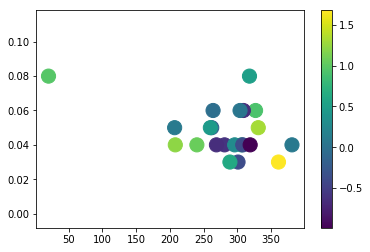

This is ml result for  AAPL 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[ 0.241  0.241] 
 [ 5.840  0.690] 

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
[ 0.194  0.177] 
 [ 5.840  0.690] 

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
[ 0.017  0.017] 
 [ 5.840  0.690] 

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)
[ 0.017  0.017] 
 [ 5.840  0.690] 

PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
        

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


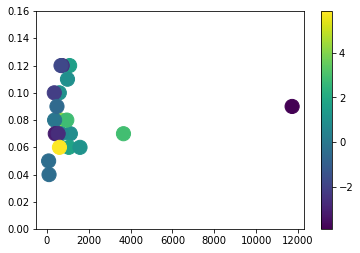

This is ml result for  TSLA 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[-0.192] 
 [-6.550] 

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
[-2.291] 
 [-6.550] 

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
[-0.565] 
 [-6.550] 

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)
[-0.565] 
 [-6.550] 

PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive',
  

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


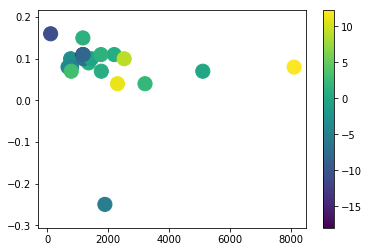

This is ml result for  CRM 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[ 0.644  0.644] 
 [ 2.590  1.320] 

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
[ 0.362  0.336] 
 [ 2.590  1.320] 

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
[ 0.419  0.419] 
 [ 2.590  1.320] 

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)
[ 0.419  0.419] 
 [ 2.590  1.320] 

PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
         

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


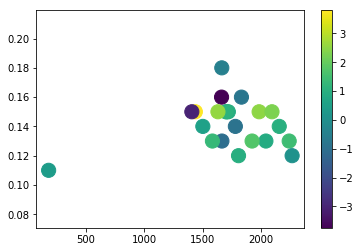

This is ml result for  NFLX 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[-1.560 -1.560] 
 [-3.860  5.950] 

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
[ 0.238  0.266] 
 [-3.860  5.950] 

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
[ 0.339  0.339] 
 [-3.860  5.950] 

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)
[ 2.563  1.617] 
 [-3.860  5.950] 

PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
        

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


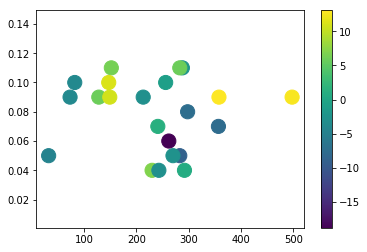

In [13]:
#main: clean all data and train and see the results

for i in range(0, len(tweet_files)):
    data = clean_and_combine(twitter_data[i], df_stock_price[stock_names[i]])
    print('This is ml result for ', stock_names[i], '\n')
    ml_model(data)
    lm_plotColorbar(data)

### Conclusion

#### Some comments on Machine Learning model:

#### For user case, we will allow user to input a stock, and with the scrapping method came in the correspondant twitter data and stock data (In reality we will have more data than right now, as we are trying to diminish processing time now for this project). 

#### With all the data, we will implement the very same method shown above to clean, and predict stock price for the next day. 